## Time Series Forecasting through Extreme Learning Machine

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Functions

In [2]:
def mse_function(Y, Y_pred):
    
    M, C = Y.shape[0], Y.shape[1] # Number of examples (M) and number of outputs (C)

    E = Y-Y_pred # Error between Y true and Y predicted
    mse = np.sum(E.T.dot(E))/(M*C) # Mean squared error
    
    return mse

In [3]:
def minmax_normalization(X, a=0, b=1):

    xmin, xmax = X.min(), X.max() # Min and max values of data
    X_norm = a + ( (X-xmin)*(b-a)/(xmax-xmin) ) # Normalized data in a new range

    return X_norm, a, b, xmin, xmax

In [4]:
def apply_minmax_normalization(X, a, b, xmin, xmax):

    X_norm = a + ( (X-xmin)*(b-a)/(xmax-xmin) ) # Normalized data in a new range

    return X_norm

In [5]:
def sliding_window(serie, lag=2, step_forward=1):

    M = len(serie) # Lenght of time series

    X = np.zeros((M-(lag+step_forward-1), lag)) # Input definition
    y = np.zeros((M-(lag+step_forward-1), 1)) # Target definition

    cont = 0
    posinput = lag + cont
    posout = posinput + step_forward

    i = 0
    while posout<=M:

        X[i, :] = serie[cont:posinput]
        y[i] = serie[posout-1]
        cont+=1
        posinput = lag+cont
        posout = posinput + step_forward
        i+=1

    return X, y

In [6]:
def elm_test(X, w1, w2):
    
    M = np.size(X, axis=0) # Number of examples
    N = np.size(X, axis=1) # Number of features

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    Xa = np.concatenate((bias, X), axis=1) # Input with bias

    S = Xa.dot(w1.T) # Weighted sum of hidden layer
    H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

    y_pred = Ha.dot(w2.T) # Predictions
    
    return y_pred

In [8]:
def elm_train(X, y, L, w1=None):
    
    M = np.size(X, axis=0) # Number of examples
    N = np.size(X, axis=1) # Number of features
    
    # If w1 is defined
    if w1 is None:
        w1 = np.random.uniform(low=-1, high=1, size=(L, N+1)) # Weights with bias

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    Xa = np.concatenate((bias, X), axis=1) # Input with bias

    S = Xa.dot(w1.T) # Weighted sum of hidden layer
    H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

    w2 = (np.linalg.pinv(Ha).dot(y)).T # w2' = pinv(Ha)*D

    y_pred = Ha.dot(w2.T) # Predictions
    
    return y_pred, w1, w2

### Time Series

In [9]:
df = pd.read_csv('../data/brazilian_gpd_ipi.csv')
df.head()

,time,GPD,IPI
0,1,91.21,92.91
1,2,91.94,91.07
2,3,104.64,100.56
3,4,100.89,93.55
4,5,105.58,102.82


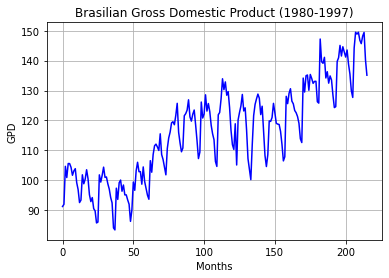

In [10]:
df.GPD.plot(color='blue')

plt.grid()
plt.xlabel('Months')
plt.ylabel('GPD')
plt.title('Brasilian Gross Domestic Product (1980-1997)')

plt.show()

### Train-test split

In [11]:
train_size = int(len(df.GPD) * 0.8)

series_train = df.GPD[:train_size].values
time_train = df.time[:train_size].values

series_test = df.GPD[train_size:].values
time_test = df.time[train_size:].values

### Training

Normalization

In [18]:
series_train_norm, a, b, xmin, xmax = minmax_normalization(series_train, a=0, b=1)
series_test_norm = a+( (series_test-xmin)*(b-a)/(xmax-xmin) )

print('Min value of time series:', series_train.min())
print('Max value of time series:', series_train.max())
print('Min value of normalized time series:', series_train_norm.min())
print('Max value of normalized time series:', series_train_norm.max())

Min value of time series: 83.37
Max value of time series: 134.17
Min value of normalized time series: 0.0
Max value of normalized time series: 1.0


Adjust the normalized data

In [33]:
lag = 2 # Size of lag
step_forward = 1 # Step forward to prediction

print('Number of lags:', lag)
print('Number of step forward:', step_forward)

# Sliding window or lag or lag method
X_train_norm, y_train_norm = sliding_window(series_train_norm, lag, step_forward)
X_test_norm, y_test_norm = sliding_window(series_test_norm, lag, step_forward)

Number of lags: 2
Number of step forward: 1


Training the model

In [ ]:
L = 5 # Number of hidden neurons

print('Number of hidden neuros:', L)

y_train_pred_norm, w1, w2 = elm_train(X_train_norm, y_train_norm, L)
y_test_pred_norm = elm_test(X_test_norm, w1, w2)

Training the model: predefined weights

In [36]:
L = 5 # Number of hidden neurons

print('Number of hidden neuros:', L)

data = np.load('models/ts-weights_1.npz')
w1 = data['w1']

y_train_pred_norm, w1, w2 = elm_train(X_train_norm, y_train_norm, L, w1=w1)
y_test_pred_norm = elm_test(X_test_norm, w1, w2)

Number of hidden neuros: 5


Revert the normalization

In [37]:
y_train_pred = apply_minmax_normalization(y_train_pred_norm, xmin, xmax, a, b)
y_test_pred = apply_minmax_normalization(y_test_pred_norm, xmin, xmax, a, b)

Adjust the data

In [38]:
# Sliding window or lag or lag method
X_train, y_train = sliding_window(series_train, lag, step_forward)
X_test, y_test = sliding_window(series_test, lag, step_forward)

In [39]:
print('Time series:', series_train[0:5])

print('\nInput matrix X:')
print(X_train[0:3])

print('\nTarget variable y:')
print(y_train[0:3])

Time series: [ 91.21  91.94 104.64 100.89 105.58]

Input matrix X:
[[ 91.21  91.94]
 [ 91.94 104.64]
 [104.64 100.89]]

Target variable y:
[[104.64]
 [100.89]
 [105.58]]


Mean squared error

In [40]:
train_mse = mse_function(y_train, y_train_pred)
test_mse = mse_function(y_test, y_test_pred)

print('Training MSE:', train_mse)
print('Testing MSE:', test_mse)

Training MSE: 30.84006348185438
Testing MSE: 42.09714866290891


### Visualization

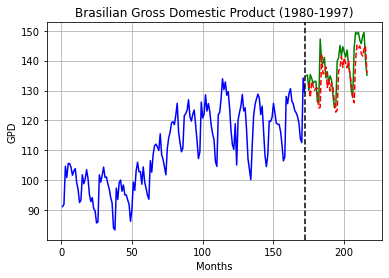

In [41]:
point = int((time_train[-1]+time_test[0])/2)

plt.plot(time_train, series_train, 'b')
plt.plot(time_test, series_test, 'g')
plt.plot(time_test[lag:], y_test_pred, 'r--')
plt.axvline(point, color='k', linestyle='--')

plt.grid()
plt.xlabel('Months')
plt.ylabel('GPD')
plt.title('Brasilian Gross Domestic Product (1980-1997)')

plt.show()